# **Home Assignment: Deep Learning from Scratch**

In [ ]:
# Install a conda package in the current Jupyter kernel
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
warnings.simplefilter("ignore")
from scipy import io
import matplotlib.pyplot as plt


# Part I: the classifier and optimizer
## Subsection I - Softmax and its gradient

For start, we will load the datasets PeaksData and GMMData to the working environment.

In [46]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')
mat2 = scipy.io.loadmat('GMMData.mat')

In [47]:
X = mat['Yt']
Y = mat['Ct']
X_val = mat['Yv']
Y_val = mat['Cv']
print(X.shape)
print(Y.shape)
X2 = mat2['Yt']
Y2 = mat2['Ct']
X2_val = mat2['Yv']
Y2_val = mat2['Cv']
print(X2.shape)
print(Y2.shape)

(2, 25000)
(5, 25000)
(5, 25000)
(5, 25000)


We will now, define the softmax function, and its gradient with respect to the weigths, baises and data.

In [48]:
import numpy as np

class softmax:
    def gradient(self, X, Y, error, W):
        M = X.shape[1]
        grad_theta = 1/M * error @ X.T
        grad_b = 1/M * np.sum(error, axis=1)
        grad_data = 1/M * W.T @ error
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        exp = np.exp(x)
        return (exp / np.sum(exp, axis=0))

The next part of the code will define our loss function which is the cross_entropy_loss.<br>
We assume that the predicted data provided to this function went through a softmax function as its most recent process before applying this loss function.<br>
Cross entropy checks the diffrence between two probabilities in the following way : $ \frac{1}{M}\sum(Y_{true} * log(Y_{predicted}))$ where m is the size of the dataset , and Y_true is 1 hot encoded vector with size L(number of classes)

In [49]:
def cross_entropy_loss(y_true, y_predicted, epsilon=1e-10):
    predictions = np.clip(y_predicted, epsilon, 1. - epsilon)
    M = predictions.shape[1]
    return -np.sum(y_true * np.log(predictions)) / M

The class linear_layer is a wrapper around simple linear layer which will later be used as a building block to our nueral network.<br>
Linear layer consists of activation function and linear function in the form : $ \sigma(AX + B) $.<br>
The function update_weigths and gradient will be later used in the SGD. Notice that the gradient function is just a wrapper around the activation layer gradient function.

In [50]:
class linear_layer:
    def __init__(self, dim_in, dim_out, activation):
        self._A = np.random.normal(.5, .5, size=(dim_out, dim_in))
        self._B = np.random.normal(.5, .5, size=(dim_out, 1))
        self._activation = activation
        self._dim_in = dim_in
        self._dim_out = dim_out
        
    def update_weigths(self, gradient_theta, gradient_b, learning_rate):
        gradient_b = gradient_b.reshape(self._dim_out, 1)
        self._A = self._A - learning_rate * gradient_theta
        self._B = self._B - learning_rate * gradient_b
    
    def gradient(self, X, Y, error):
        return self._activation.gradient(X, Y, error, self._A)
    
    def dim_in(self):
        return self._dim_in
    
    def dim_out(self):
        return self._dim_out
    
    def activate_with_weigths_change(self, d, X):
        return self._activation((self._A + d) @ X + self._B)
        
    def activate_with_biases_change(self, d, X):
        return self._activation(self._A @ X + (self._B + d))
    
    def jacobain(self, X, Y, vec, kind):
        return self._activation.jacobain(X, Y, self._A, vec, kind)
    
    def __call__(self, X):
        return self._activation(self._A @ X + self._B)

In general the gradient test is defined as follows : we know that $ |f(x + \epsilon*d) - f(x)| = O(\epsilon) $ , we want to check that $ |f(x + \epsilon*d) - f(x) - \epsilon*d*grad(x)| = O(\epsilon^2) $ <br>
We can now check that our linear function with softmax activation passes the gradient test, where $ f(x) = Loss(Y_{true}, Y_{predicted}) $.<br>
We will start by checking the gradient with respect to the data.<br>
Notice that since we only check the gradient with respect to the data, the random vector $ \epsilon * d $ is added the data in the following way $ f(\sigma(A(X + \epsilon * d) + b)) $

In [51]:
def create_random_vector(dim_in, dim_out):
    d = np.random.normal(.5, .5, size=(dim_in, dim_out))
    return d / np.linalg.norm(d)

def gradient_test_with_respect_to_data(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d_input = create_random_vector(dim_in, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d_input
        predictions = linear_layer(X)
        predictions_d = linear_layer(X + vec)
        _, _, grad_data = linear_layer.gradient(X, Y, predictions - Y)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_data).reshape(1)))
    return without_gradient, with_gradient

In each iteration of the gradient test we define $ \epsilon = 0.5^i $ where i is the number of the current iteration. <br>
We will then draw those 2 lines in log scale, and we expect that the second formula (with the gradient) will converge faster.

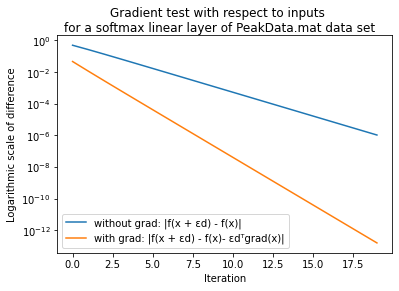

In [52]:
without_grad, with_grad = gradient_test_with_respect_to_data(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

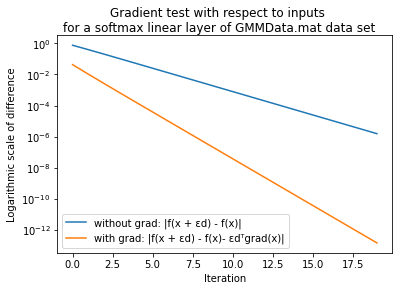

In [53]:
without_grad, with_grad = gradient_test_with_respect_to_data(cross_entropy_loss, linear_layer(5,5, softmax()),
                                                               X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

The following code test the gradient with respect to the baises, the basic idea of the gradient test applies here as well we only need to make small modifications, we need to add the random vector $ \epsilon * d $ to the baises instead of the data 
$ f(\sigma(A^TX + (b + \epsilon * d))) $ <br>
Regarding this test we will use the gradient of the softmax function with respect to the baises.

In [54]:
def gradient_test_with_respect_to_baises(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, 1)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_biases_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        _, grad_baises, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - vec.T.dot(grad_baises).reshape(1)))
    return without_gradient, with_gradient

We expect the same result here as we got in the gradient test with respect to the data

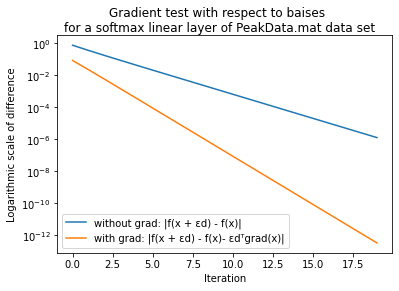

In [55]:
without_grad, with_grad = gradient_test_with_respect_to_baises(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                               X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to baises \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

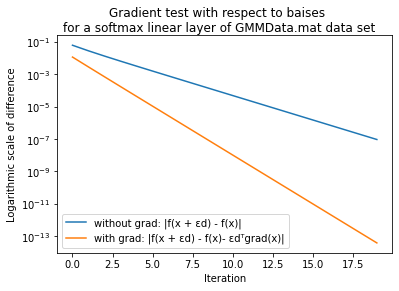

In [56]:
without_grad, with_grad = gradient_test_with_respect_to_baises(cross_entropy_loss, linear_layer(5,5, softmax()),
                                                               X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to baises \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

For the final test, we will test the gradient with respect to the weigths. we will now add the random vector $ \epsilon * d $ to the weights as follows : $ f(\sigma((A+\epsilon * d)X + b)) $

In [57]:
def gradient_test_with_respect_to_weigths(loss, linear_layer, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    d = create_random_vector(dim_out, dim_in)
    without_gradient = []
    with_gradient = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = linear_layer(X)
        predictions_d = linear_layer.activate_with_weigths_change(vec, X)
        diff_f = loss(Y, predictions_d) - loss(Y, predictions)
        without_gradient.append(np.abs(diff_f))
        grad_theta, _, _ = linear_layer.gradient(X, Y, predictions - Y)
        with_gradient.append(np.abs(diff_f - (np.ravel(vec) @ np.ravel(grad_theta)).reshape(1)))
    return without_gradient, with_gradient

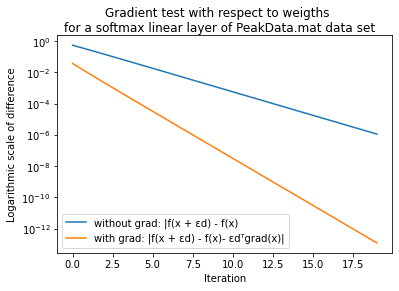

In [58]:
without_grad, with_grad = gradient_test_with_respect_to_weigths(cross_entropy_loss, linear_layer(2,5, softmax()),
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to weigths \nfor a softmax linear layer of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

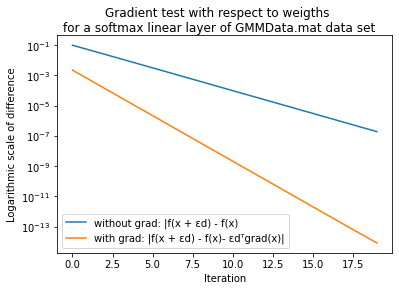

In [60]:
without_grad, with_grad = gradient_test_with_respect_to_weigths(cross_entropy_loss, linear_layer(5,5, softmax()),
                                                                X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))
plt.suptitle('Gradient test with respect to weigths \nfor a softmax linear layer of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

As we can see, the test result shows a relation of square values between the subtraction results with and without the gradient for all three tests and for both data sets as expected.<br>
we can clearly see that our linear_layer passes the gradient test and we can move on to the second part, which is writing the SGD.

## Subsection II - SGD
Before we start writing the SGD, we will define the class sequential_model which is just a wrapper over some linear_layers, and will help calculting the output of the model and the total gradient.<br>
Note that this class also saves the outputs after each layer to be later used in the gradient function.

In [61]:
class sequential_model:
    def __init__(self, *layers):
        self._layers = []
        self._history = []
        last_dim_out = 0
        for layer in layers:
            if last_dim_out != 0 and last_dim_out != layer.dim_in():
                print('dimension dont match layer out dim {} , next layer dim in {}'.format(last_dim_out, layer.dim_in()))
                raise 
            self._layers.append(layer)
            last_dim_out = layer.dim_out()

    def gradient(self, Y_true):
        gradient = []
        error = self._history[-1] - Y_true
        for i in range(1, len(self._layers) + 1):
            X = self._history[-i - 1]
            Y = self._history[-i]
            gradient_theta, gradient_b, error = self._layers[-i].gradient(X, Y, error)
            gradient.append((gradient_theta, gradient_b, error))
        return gradient
    
    def __call__(self, X):
        new_X = np.array(X, copy=True) 
        self._history = []
        self._history.append(new_X)
        for layer in self._layers:
            new_X = layer(new_X)
            self._history.append(new_X)
        return new_X

    def layers(self):
        return self._layers

The accuracy function is defined as follows : $ \frac{argmax(Y_{true}) = argmax(Y_{predicted})}{size} $

In [62]:
def accuracy(Y_true, Y_predicted):
    return np.sum(np.argmax(Y_true, axis=0) == np.argmax(Y_predicted, axis=0)) / Y_true.shape[1]

Now we will define out SGD , this function receives the model as input and in each epoch , it updates the weigths based on the gradient. Then it calculates the accuracy and the loss for the train set and the validation set.<br>
Importent thing to note is that each layer updates its own weights according to the gradient calculated up to this point.

In [63]:
import math

def update_weigths(model, learning_rate, Y_true):
    grad = model.gradient(Y_true)
    for i, (gradient_theta, gradient_b, error) in enumerate(reversed(grad)):
        model.layers()[i].update_weigths(gradient_theta, gradient_b, learning_rate)


def SGD(model, X, Y, X_val, Y_val, epoch, learning_rate, loss, batch_size):
    accuracy_train = []
    accuracy_val = []
    loss_train = []
    loss_val = []
    number_of_iterations = math.ceil(X.shape[1] / batch_size)
    for i in range(epoch):
        iter_accuracy = 0
        iter_loss = 0
        for j in range(0, X.shape[1], batch_size):
            Y_predicted = model(X[:, j:j+batch_size])
            update_weigths(model, learning_rate, Y[:, j:j+batch_size])
            iter_accuracy += accuracy(Y[:, j:j+batch_size], Y_predicted)
            iter_loss += loss(Y[:, j:j+batch_size], Y_predicted)
        Y_predicted_val = model(X_val)
        accuracy_train.append(iter_accuracy / number_of_iterations)
        loss_train.append(iter_loss / number_of_iterations)
        accuracy_val.append(accuracy(Y_val, Y_predicted_val))
        loss_val.append(cross_entropy_loss(Y_val, Y_predicted_val))
    return loss_train, accuracy_train, loss_val, accuracy_val

We will now check that the SGD minimize the objective function.

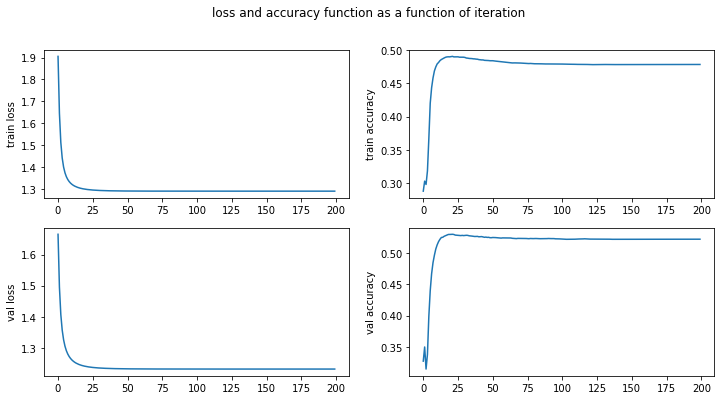

In [64]:
import matplotlib.pyplot as plt

model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X, Y, X_val, Y_val, 200, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

And now for the GMM dataset.

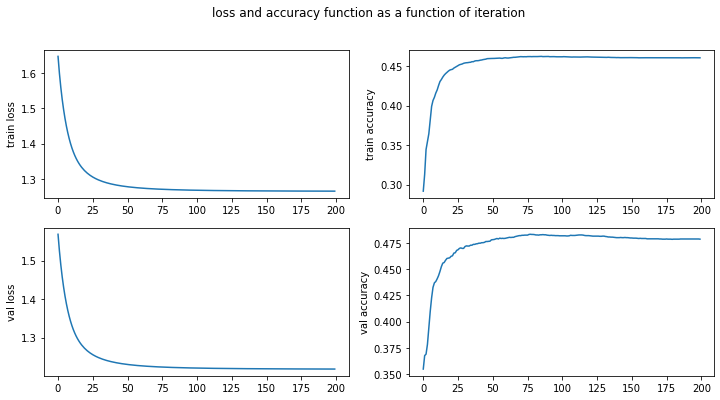

In [65]:
model = sequential_model(
        linear_layer(5, 5, activation=softmax())
        )

train_loss, train_accuracy, val_loss, val_accuracy = SGD(model, X2, Y2, X2_val, Y2_val, 200, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy)
axs[1][1].set_ylabel('val accuracy')

plt.show()

The SGD works as expected , but we see that the loss converges which probably means that we need to pick new hyper parameters or the model isn't expressive enought.<br>
In the next section we will see how to choose the right hypter parameters using a grid search.

## Subsection III - SGD Hyper Parameters

In order to find the best parameters for the learning process, we will define a grid search function. Given some hyper paramters lists, the function will activate different combinations and will demonstrate the results, allowing us to find the best one.

In [66]:
def grid_search(model_init, X, Y, X_val, Y_val, learning_rate_values, iteration_values, batch_size_values):
    train_accuracy = []
    val_accuracy = []
    val_loss = []
    train_loss = []
    for learning_rate in learning_rate_values:
        for iteration_num in iteration_values:
            for batch_size in batch_size_values:
                model = model_init()
                loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, Y, X_val, Y_val, iteration_num, learning_rate, cross_entropy_loss, batch_size)
                train_accuracy.append(accuracy_train)
                val_accuracy.append(accuracy_val)
                train_loss.append(loss_train)
                val_loss.append(loss_val)
    return train_accuracy, train_loss, val_accuracy, val_loss

We will now test our grid function and plot the best results, according to the best validation accuracy.

In [67]:
learning_rates = [0.2, 0.1, 0.05, 0.01, 0.001]
iteration_values = [10, 20, 50, 100, 200]
batch_sizes = [50, 100, 500, 1000, 25000]

train_accuracy, train_loss, val_accuracy, val_loss = grid_search(lambda : sequential_model(linear_layer(2, 5, activation=softmax())), X, Y, X_val, Y_val, learning_rates, iteration_values, batch_sizes)

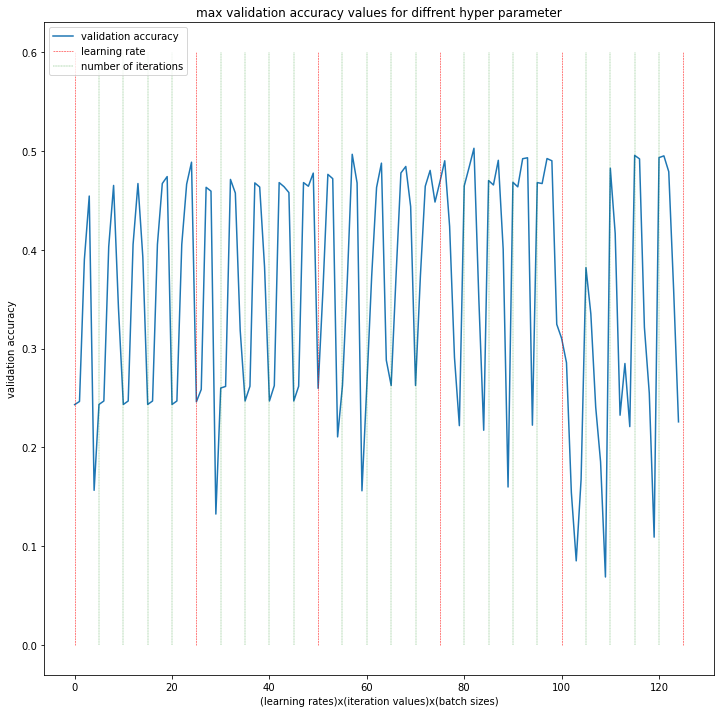

In [136]:
max_values = list(map(lambda x : max(x), val_accuracy))

plt.figure(figsize=(12,12))
plt.plot(max_values)
plt.title("max validation accuracy values for diffrent hyper parameter")
plt.ylabel('validation accuracy')
plt.xlabel('(learning rates)x(iteration values)x(batch sizes)')
plt.plot([25, 25], [0, 0.6], 'r--', lw=0.5, label="iteration values")
a = plt.plot([5, 5], [0, 0.6], 'g--', lw=0.3, label="number of iterations")
plt.plot([50, 50], [0, 0.6], 'r--', lw=0.5,)
plt.plot([75, 75], [0, 0.6], 'r--', lw=0.5,)
plt.plot([100, 100], [0, 0.6], 'r--', lw=0.5,)
plt.plot([0, 0], [0, 0.6], 'r--', lw=0.5,)
plt.plot([125, 125], [0, 0.6], 'r--', lw=0.5,)
plt.plot([10, 10], [0, 0.6], 'g--', lw=0.3,)
plt.plot([15, 15], [0, 0.6], 'g--', lw=0.3,)
plt.plot([20, 20], [0, 0.6], 'g--', lw=0.3,)
plt.plot([30, 30], [0, 0.6], 'g--', lw=0.3,)
plt.plot([35, 35], [0, 0.6], 'g--', lw=0.3,)
plt.plot([40, 40], [0, 0.6], 'g--', lw=0.3,)
plt.plot([45, 45], [0, 0.6], 'g--', lw=0.3,)
plt.plot([55, 55], [0, 0.6], 'g--', lw=0.3,)
plt.plot([60, 60], [0, 0.6], 'g--', lw=0.3,)
plt.plot([65, 65], [0, 0.6], 'g--', lw=0.3,)
plt.plot([70, 70], [0, 0.6], 'g--', lw=0.3,)
plt.plot([80, 80], [0, 0.6], 'g--', lw=0.3,)
plt.plot([85, 85], [0, 0.6], 'g--', lw=0.3,)
plt.plot([90, 90], [0, 0.6], 'g--', lw=0.3,)
plt.plot([95, 95], [0, 0.6], 'g--', lw=0.3,)
plt.plot([105, 105], [0, 0.6], 'g--', lw=0.3,)
plt.plot([110, 110], [0, 0.6], 'g--', lw=0.3,)
plt.plot([115, 115], [0, 0.6], 'g--', lw=0.3,)
plt.plot([120, 120], [0, 0.6], 'g--', lw=0.3)

plt.legend(['validation accuracy', 'learning rate', 'number of iterations'], loc='upper left')

plt.show()

batch sizes are 50, 100, 500, 1000, 25000


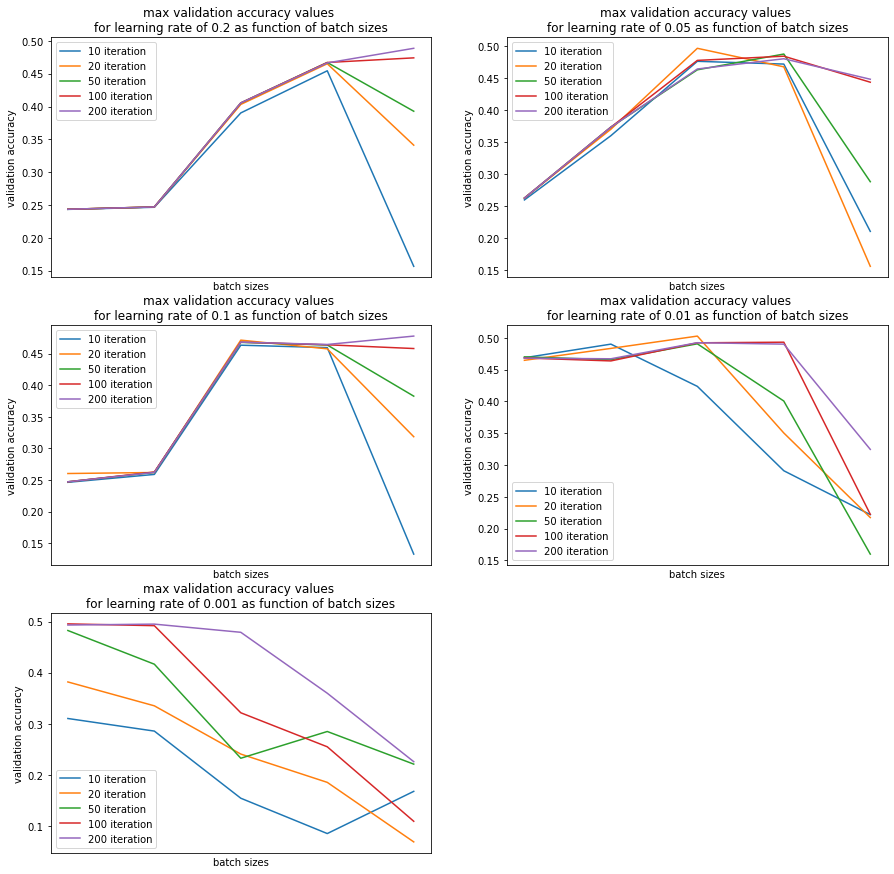

In [151]:
max_values = list(map(lambda x : max(x), val_accuracy))

batch_sizes_1 = []
batch_sizes_2 = []
batch_sizes_3 = []
batch_sizes_4 = []
batch_sizes_5 = []

batch_sizes_1B = []
batch_sizes_2B = []
batch_sizes_3B = []
batch_sizes_4B = []
batch_sizes_5B = []

batch_sizes_1C = []
batch_sizes_2C = []
batch_sizes_3C = []
batch_sizes_4C = []
batch_sizes_5C = []

batch_sizes_1D = []
batch_sizes_2D = []
batch_sizes_3D = []
batch_sizes_4D = []
batch_sizes_5D = []

batch_sizes_1E = []
batch_sizes_2E = []
batch_sizes_3E = []
batch_sizes_4E = []
batch_sizes_5E = []


for i in range(5):
    batch_sizes_1.append(max_values[i])
    batch_sizes_2.append(max_values[i+5])
    batch_sizes_3.append(max_values[i+10]) 
    batch_sizes_4.append(max_values[i+15])
    batch_sizes_5.append(max_values[i+20])
    batch_sizes_1B.append(max_values[i+25])
    batch_sizes_2B.append(max_values[i+5+25])
    batch_sizes_3B.append(max_values[i+10+25]) 
    batch_sizes_4B.append(max_values[i+15+25])
    batch_sizes_5B.append(max_values[i+20+25])
    batch_sizes_1C.append(max_values[i+50])
    batch_sizes_2C.append(max_values[i+5+50])
    batch_sizes_3C.append(max_values[i+10+50]) 
    batch_sizes_4C.append(max_values[i+15+50])
    batch_sizes_5C.append(max_values[i+20+50])
    batch_sizes_1D.append(max_values[i+75])
    batch_sizes_2D.append(max_values[i+5+75])
    batch_sizes_3D.append(max_values[i+10+75]) 
    batch_sizes_4D.append(max_values[i+15+75])
    batch_sizes_5D.append(max_values[i+20+75])
    batch_sizes_1E.append(max_values[i+100])
    batch_sizes_2E.append(max_values[i+5+100])
    batch_sizes_3E.append(max_values[i+10+100]) 
    batch_sizes_4E.append(max_values[i+15+100])
    batch_sizes_5E.append(max_values[i+20+100])


print('batch sizes are 50, 100, 500, 1000, 25000')
fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.title("max validation accuracy values for diffrent hyper parameter")

axs[0][0].plot(batch_sizes_1)
axs[0][0].plot(batch_sizes_2)
axs[0][0].plot(batch_sizes_3)
axs[0][0].plot(batch_sizes_4)
axs[0][0].plot(batch_sizes_5)
axs[0][0].set_title("max validation accuracy values \nfor learning rate of 0.2 as function of batch sizes")
axs[0][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][0].set_xticks([])

axs[1][0].plot(batch_sizes_1B)
axs[1][0].plot(batch_sizes_2B)
axs[1][0].plot(batch_sizes_3B)
axs[1][0].plot(batch_sizes_4B)
axs[1][0].plot(batch_sizes_5B)
axs[1][0].set_title("max validation accuracy values \nfor learning rate of 0.1 as function of batch sizes")
axs[1][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')

axs[1][0].set_xticks([])


axs[0][1].plot(batch_sizes_1C)
axs[0][1].plot(batch_sizes_2C)
axs[0][1].plot(batch_sizes_3C)
axs[0][1].plot(batch_sizes_4C)
axs[0][1].plot(batch_sizes_5C)
axs[0][1].set_title("max validation accuracy values \nfor learning rate of 0.05 as function of batch sizes")
axs[0][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][1].set_xticks([])


axs[1][1].plot(batch_sizes_1D)
axs[1][1].plot(batch_sizes_2D)
axs[1][1].plot(batch_sizes_3D)
axs[1][1].plot(batch_sizes_4D)
axs[1][1].plot(batch_sizes_5D)
axs[1][1].set_title("max validation accuracy values \nfor learning rate of 0.01 as function of batch sizes")
axs[1][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')

axs[1][1].set_xticks([])



axs[2][0].plot(batch_sizes_1E)
axs[2][0].plot(batch_sizes_2E)
axs[2][0].plot(batch_sizes_3E)
axs[2][0].plot(batch_sizes_4E)
axs[2][0].plot(batch_sizes_5E)
axs[2][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[2][0].set_xticks([])

axs[2][0].set_title("max validation accuracy values \nfor learning rate of 0.001 as function of batch sizes")
axs[2][0].set_ylabel('validation accuracy')
axs[2][0].set_xlabel('batch sizes')

axs[0][0].set_ylabel('validation accuracy')
axs[0][0].set_xlabel('batch sizes')
axs[1][0].set_ylabel('validation accuracy')
axs[1][0].set_xlabel('batch sizes')
axs[0][1].set_ylabel('validation accuracy')
axs[0][1].set_xlabel('batch sizes')
axs[1][1].set_ylabel('validation accuracy')
axs[1][1].set_xlabel('batch sizes')


axs[2][1].set_visible(False)


plt.ylabel('validation accuracy')


plt.show()


We can see that increasing the batch size relly effect the performence of the model.<br>
Also smaller learning rates with very small number of iterations results in an underfitted model as we expected.

the best val accuracy is obtained using learning_rate = 0.01, num_iterations = 20, batch_size = 500
best accuracy : 0.50272


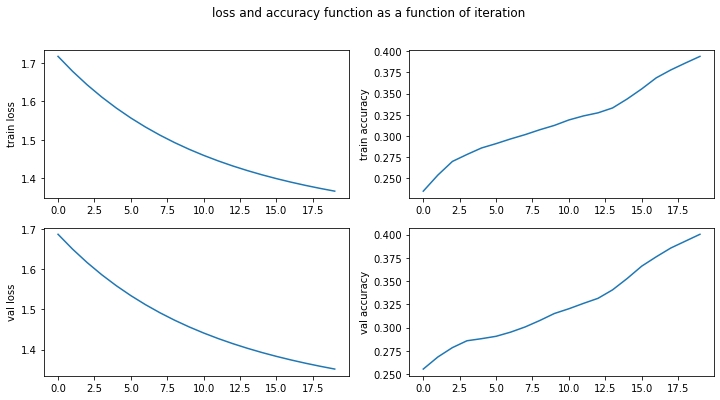

In [158]:
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning_rate = {}, num_iterations = {}, batch_size = {}'.format(learning_rates[int(index / 25)], iteration_values[int(index / 5) % 5], batch_sizes[index % 5]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

We will repeat that process for the GMM data.

In [153]:
train_accuracy, train_loss, val_accuracy, val_loss = grid_search(lambda : sequential_model(linear_layer(5, 5, activation=softmax())), X2, Y2, X2_val, Y2_val, learning_rates, iteration_values, batch_sizes)

batch sizes are 50, 100, 500, 1000, 25000


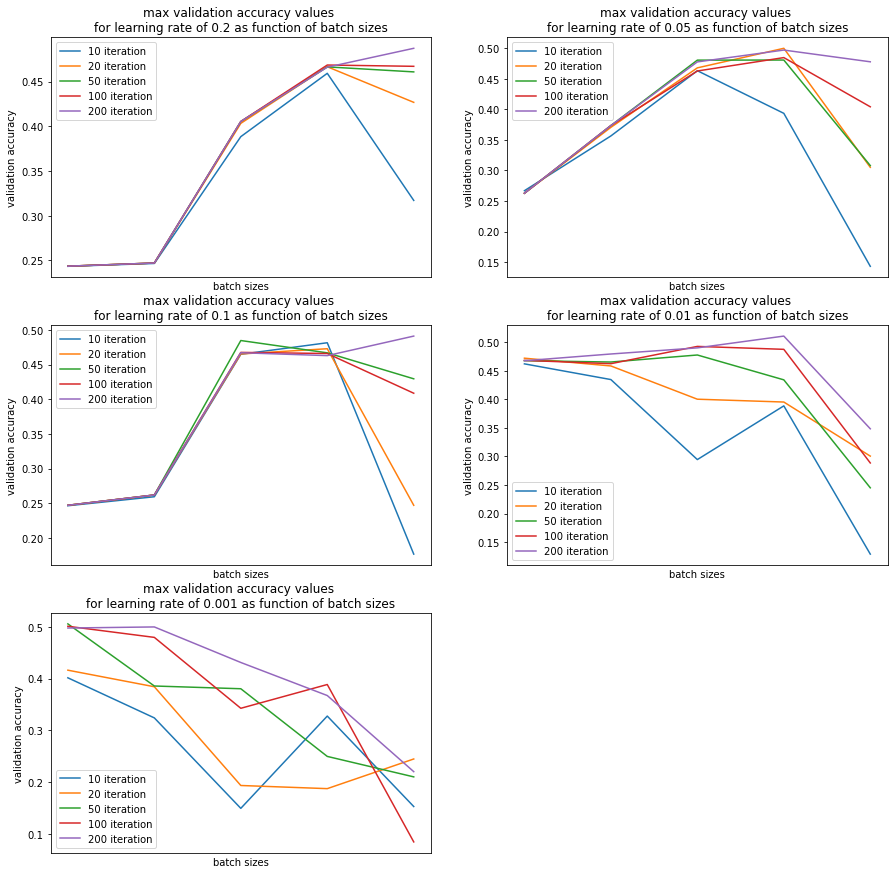

In [159]:
max_values = list(map(lambda x : max(x), val_accuracy))

batch_sizes_1 = []
batch_sizes_2 = []
batch_sizes_3 = []
batch_sizes_4 = []
batch_sizes_5 = []

batch_sizes_1B = []
batch_sizes_2B = []
batch_sizes_3B = []
batch_sizes_4B = []
batch_sizes_5B = []

batch_sizes_1C = []
batch_sizes_2C = []
batch_sizes_3C = []
batch_sizes_4C = []
batch_sizes_5C = []

batch_sizes_1D = []
batch_sizes_2D = []
batch_sizes_3D = []
batch_sizes_4D = []
batch_sizes_5D = []

batch_sizes_1E = []
batch_sizes_2E = []
batch_sizes_3E = []
batch_sizes_4E = []
batch_sizes_5E = []


for i in range(5):
    batch_sizes_1.append(max_values[i])
    batch_sizes_2.append(max_values[i+5])
    batch_sizes_3.append(max_values[i+10]) 
    batch_sizes_4.append(max_values[i+15])
    batch_sizes_5.append(max_values[i+20])
    batch_sizes_1B.append(max_values[i+25])
    batch_sizes_2B.append(max_values[i+5+25])
    batch_sizes_3B.append(max_values[i+10+25]) 
    batch_sizes_4B.append(max_values[i+15+25])
    batch_sizes_5B.append(max_values[i+20+25])
    batch_sizes_1C.append(max_values[i+50])
    batch_sizes_2C.append(max_values[i+5+50])
    batch_sizes_3C.append(max_values[i+10+50]) 
    batch_sizes_4C.append(max_values[i+15+50])
    batch_sizes_5C.append(max_values[i+20+50])
    batch_sizes_1D.append(max_values[i+75])
    batch_sizes_2D.append(max_values[i+5+75])
    batch_sizes_3D.append(max_values[i+10+75]) 
    batch_sizes_4D.append(max_values[i+15+75])
    batch_sizes_5D.append(max_values[i+20+75])
    batch_sizes_1E.append(max_values[i+100])
    batch_sizes_2E.append(max_values[i+5+100])
    batch_sizes_3E.append(max_values[i+10+100]) 
    batch_sizes_4E.append(max_values[i+15+100])
    batch_sizes_5E.append(max_values[i+20+100])


print('batch sizes are 50, 100, 500, 1000, 25000')
fig, axs = plt.subplots(3,2, figsize=(15,15))
plt.title("max validation accuracy values for diffrent hyper parameter")

axs[0][0].plot(batch_sizes_1)
axs[0][0].plot(batch_sizes_2)
axs[0][0].plot(batch_sizes_3)
axs[0][0].plot(batch_sizes_4)
axs[0][0].plot(batch_sizes_5)
axs[0][0].set_title("max validation accuracy values \nfor learning rate of 0.2 as function of batch sizes")
axs[0][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][0].set_xticks([])

axs[1][0].plot(batch_sizes_1B)
axs[1][0].plot(batch_sizes_2B)
axs[1][0].plot(batch_sizes_3B)
axs[1][0].plot(batch_sizes_4B)
axs[1][0].plot(batch_sizes_5B)
axs[1][0].set_title("max validation accuracy values \nfor learning rate of 0.1 as function of batch sizes")
axs[1][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')

axs[1][0].set_xticks([])


axs[0][1].plot(batch_sizes_1C)
axs[0][1].plot(batch_sizes_2C)
axs[0][1].plot(batch_sizes_3C)
axs[0][1].plot(batch_sizes_4C)
axs[0][1].plot(batch_sizes_5C)
axs[0][1].set_title("max validation accuracy values \nfor learning rate of 0.05 as function of batch sizes")
axs[0][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='upper left')
axs[0][1].set_xticks([])


axs[1][1].plot(batch_sizes_1D)
axs[1][1].plot(batch_sizes_2D)
axs[1][1].plot(batch_sizes_3D)
axs[1][1].plot(batch_sizes_4D)
axs[1][1].plot(batch_sizes_5D)
axs[1][1].set_title("max validation accuracy values \nfor learning rate of 0.01 as function of batch sizes")
axs[1][1].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')

axs[1][1].set_xticks([])



axs[2][0].plot(batch_sizes_1E)
axs[2][0].plot(batch_sizes_2E)
axs[2][0].plot(batch_sizes_3E)
axs[2][0].plot(batch_sizes_4E)
axs[2][0].plot(batch_sizes_5E)
axs[2][0].legend(['10 iteration','20 iteration','50 iteration','100 iteration','200 iteration'], loc='lower left')
axs[2][0].set_xticks([])

axs[2][0].set_title("max validation accuracy values \nfor learning rate of 0.001 as function of batch sizes")
axs[2][0].set_ylabel('validation accuracy')
axs[2][0].set_xlabel('batch sizes')

axs[0][0].set_ylabel('validation accuracy')
axs[0][0].set_xlabel('batch sizes')
axs[1][0].set_ylabel('validation accuracy')
axs[1][0].set_xlabel('batch sizes')
axs[0][1].set_ylabel('validation accuracy')
axs[0][1].set_xlabel('batch sizes')
axs[1][1].set_ylabel('validation accuracy')
axs[1][1].set_xlabel('batch sizes')


axs[2][1].set_visible(False)


plt.ylabel('validation accuracy')


plt.show()


the best val accuracy is obtained using learning_rate = 0.01, num_iterations = 200, batch_size = 1000
best accuracy : 0.51088


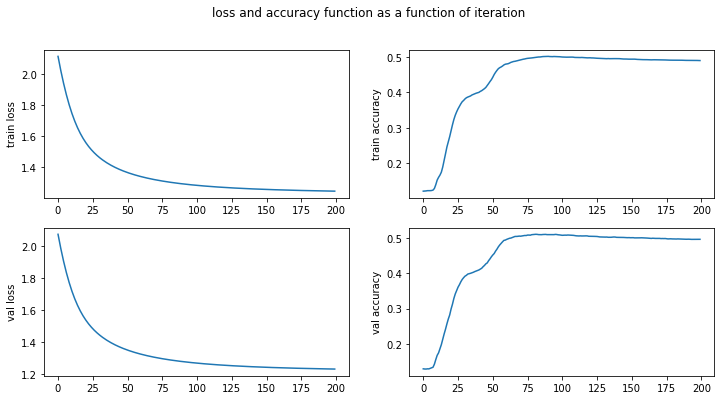

In [160]:
max_values = list(map(lambda x : max(x), val_accuracy))
index = np.argmax(max_values)

print('the best val accuracy is obtained using learning_rate = {}, num_iterations = {}, batch_size = {}'.format(learning_rates[int(index / 25)], iteration_values[int(index / 5) % 5], batch_sizes[index % 5]))
print('best accuracy : {}'.format(np.max(max_values)))

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(train_loss[index])
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(train_accuracy[index])
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(val_loss[index])
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(val_accuracy[index])
axs[1][1].set_ylabel('val accuracy')

plt.show()

For conclusion we saw how to pick the right hyper parameters using grid search, this method is very time consuming but it's completly automated, so we can "just run it and go do somthing else".<br>
Since our models reached very low accuracy, we now know that those models arn't expressive enought and we need to add more layers.<br> In the next section we will define a complete NN and test it to see that our derivatives are correct.

# Part II: the neural network
## Subsection I : NN and Jacobian Tests

The following code defines the tanh activation function and it's Jacobian with respect to the biases, weights and data.

In [162]:
class tanh:
    def gradient(self, X, Y, error, W):
        new_error = (1 - Y**2) * error
        grad_theta = new_error @ X.T 
        grad_b = np.sum(new_error, axis=1)
        grad_data = W.T @ new_error
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        return np.tanh(x)

We will now define the Jacobian test of a linear layer with tanh activation, the diffrence between the gradient test and the Jacobian test is that the function we are checking is a vector function and not scalar.<br>
The direct Jacobian transposed test is defined as follows:<br>
note : $ f(x) = tanh(AX + B) $ we will define new function $ g(x) = f(x)^Tu $ where u is a random vector in the size of the output of f(x).<br>
Now after we have the definition of g(x) we can again use the gradient test as we did in the first section, the only diffrence is the derevitive of g(x) is now $ J^Tu $ where J is the Jacobian matrix.

In [163]:
def g(linear_layer, x, u):
    return (linear_layer(x).T @ u).reshape(1)

def jacobain_test_with_respect_to_inputs(linear_layer, X):
    without_jacobain = []
    with_jacobain = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_in, 1)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = g(linear_layer, X, u)
        predictions_d = g(linear_layer, X + vec, u)
        _, _, jacob_txv = linear_layer.gradient(X, linear_layer(X), u)
        diff_f = predictions_d - predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - vec.T.dot(jacob_txv).reshape(1)))
    return without_jacobain, with_jacobain

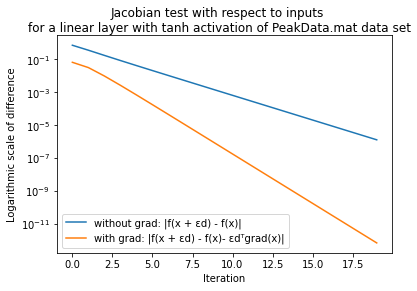

In [165]:
without_jacobain, with_jacobain = jacobain_test_with_respect_to_inputs(linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))

plt.suptitle('Jacobian test with respect to inputs \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_jacobain, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobain, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

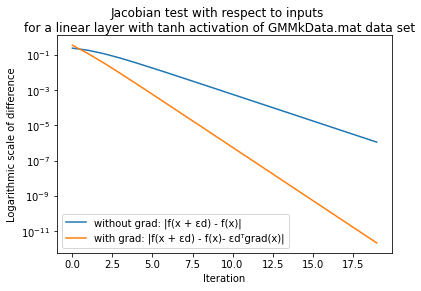

In [168]:
without_jacobain, with_jacobain = jacobain_test_with_respect_to_inputs(linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))

plt.suptitle('Jacobian test with respect to inputs \nfor a linear layer with tanh activation of GMMkData.mat data set')
plt.plot(without_jacobain, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobain, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [169]:
def g(linear_layer, x, d, u):
    return linear_layer.activate_with_weigths_change(d, x), (linear_layer.activate_with_weigths_change(d, x).T @ u).reshape(1)

def jacobain_test_with_respect_to_weigths(linear_layer, X):
    without_jacobain = []
    with_jacobain = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_out, dim_in)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        Y, predictions = g(linear_layer, X, 0, u)
        _, predictions_d = g(linear_layer, X, vec, u)
        jacob_twu, _, _ = linear_layer.gradient(X, Y, u)
        diff_f = predictions_d - predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - (np.ravel(vec) @ np.ravel(jacob_twu)).reshape(1)))
    return without_jacobain, with_jacobain

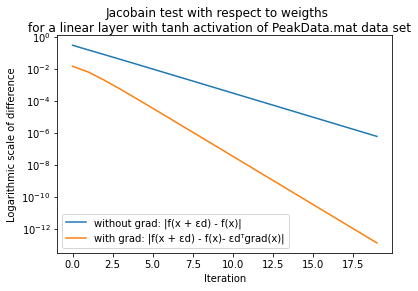

In [170]:
without_jacobain, with_jacobain = jacobain_test_with_respect_to_weigths(linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))

plt.suptitle('Jacobain test with respect to weigths \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_jacobain, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobain, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

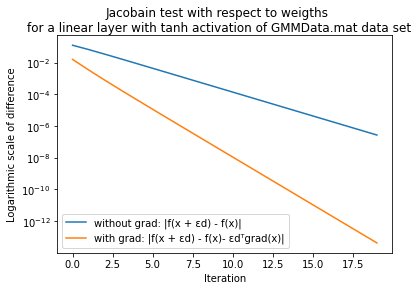

In [171]:
without_jacobain, with_jacobain = jacobain_test_with_respect_to_weigths(linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))

plt.suptitle('Jacobain test with respect to weigths \nfor a linear layer with tanh activation of GMMData.mat data set')
plt.plot(without_jacobain, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_jacobain, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [172]:
def g(linear_layer, x, d, u):
    return linear_layer.activate_with_biases_change(d, x), (linear_layer.activate_with_biases_change(d, x).T @ u).reshape(1)

def jacobain_test_with_respect_to_biases(linear_layer, X):
    without_jacobain = []
    with_jacobain = []
    dim_out = linear_layer.dim_out()
    dim_in = linear_layer.dim_in()
    d = create_random_vector(dim_out, 1)
    u = create_random_vector(dim_out, 1)
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        Y, predictions = g(linear_layer, X, 0, u)
        _, predictions_d = g(linear_layer, X, vec, u)
        _, jacob_tbu, _ = linear_layer.gradient(X, Y, u)
        diff_f = predictions_d - predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - vec.T.dot(jacob_tbu).reshape(1)))
    return without_jacobain, with_jacobain

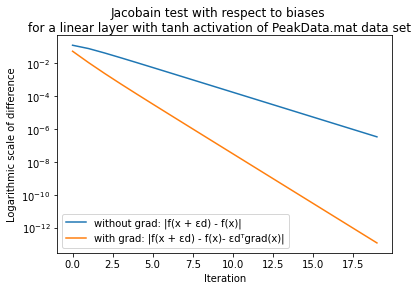

In [173]:
without_grad, with_grad = jacobain_test_with_respect_to_biases(linear_layer(2,5, tanh()), X[:, 0].reshape(2,1))

plt.suptitle('Jacobain test with respect to biases \nfor a linear layer with tanh activation of PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

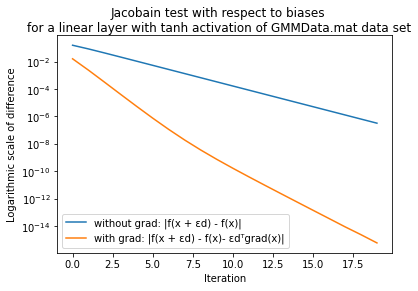

In [174]:
without_grad, with_grad = jacobain_test_with_respect_to_biases(linear_layer(5,5, tanh()), X2[:, 0].reshape(5,1))

plt.suptitle('Jacobain test with respect to biases \nfor a linear layer with tanh activation of GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)|')
plt.plot(with_grad, label= 'with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.legend()
plt.show()

In [175]:
def relu_der (x):
    if x > 0:
        return 1
    else :
        return 0
relu_der2  = np.vectorize(relu_der)

class relu:
    def gradient(self, X, Y, error, W):
        a = relu_der2(Y)
        error2 = error * a
        grad_theta = X @ error2.T
        grad_b = np.sum(error2, axis=1)
        grad_data = W.T @ error2
        return grad_theta, grad_b, grad_data

        
    def __call__(self, x):
        return (abs(x)+x)/2

In [176]:
def activate_with_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer(new_X + d[i])
    return new_X

In [177]:
def model_gradient_test_with_respect_to_inputs(loss, model, X, Y):
    without_jacobain = []
    with_jacobain = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_in(), 1))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[2], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - sum([vec[i - 1].T.dot(grad[-i]).reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobain, with_jacobain

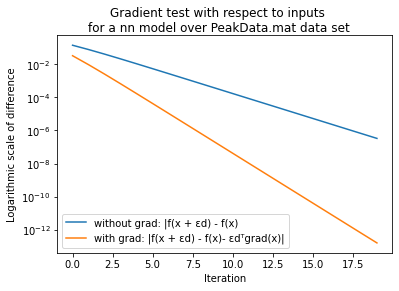

In [178]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax())
        )


without_grad, with_grad = model_gradient_test_with_respect_to_inputs(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

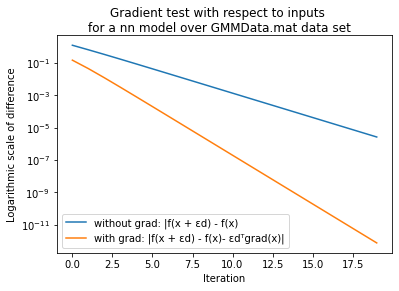

In [181]:
model2 = sequential_model(
        linear_layer(5, 5, activation=tanh()),
        linear_layer(5, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax())
        )


without_grad, with_grad = model_gradient_test_with_respect_to_inputs(cross_entropy_loss, model2,
                                                                X2[:, 0].reshape(5,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

In [182]:
def activate_with_weigths_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer.activate_with_weigths_change(d[i], new_X)
    return new_X

In [183]:
def model_gradient_test_with_respect_to_weigths(loss, model, X, Y):
    without_jacobain = []
    with_jacobain = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_out(), layers[j].dim_in()))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[0], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_weigths_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - sum([(np.ravel(vec[i - 1]) @ np.ravel(grad[-i])).reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobain, with_jacobain

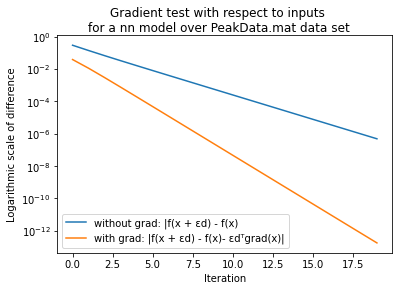

In [184]:
without_grad, with_grad = model_gradient_test_with_respect_to_weigths(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

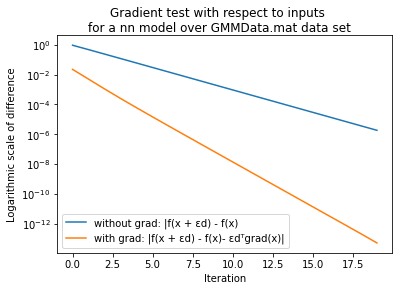

In [192]:
without_grad, with_grad = model_gradient_test_with_respect_to_weigths(cross_entropy_loss, model2,
                                                                X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to inputs \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

In [191]:
def activate_with_biases_matrix(model, d, X):
    new_X = np.array(X, copy=True)
    for i, layer in enumerate(model.layers()):
        new_X = layer.activate_with_biases_change(d[i], new_X)
    return new_X

In [188]:
def model_gradient_test_with_respect_to_biases(loss, model, X, Y):
    without_jacobain = []
    with_jacobain = []
    layers = model.layers()
    lay_len = len(layers)
    d_array = []
    for j in range(lay_len):
        d_array.append(create_random_vector(layers[j].dim_out(), 1))
    for k in range(20):
        e = np.power(0.5, k)
        predictions = model(X)
        grad = list(map(lambda x : x[1], model.gradient(Y)))
        vec = list(map(lambda x: x * e, d_array))
        loss_predictions = loss(Y, predictions)
        loss_predictions_d = loss(Y, activate_with_biases_matrix(model, vec, X))
        diff_f = loss_predictions_d - loss_predictions
        without_jacobain.append(np.abs(diff_f))
        with_jacobain.append(np.abs(diff_f - sum([(vec[i - 1].T.dot(grad[-i])).reshape(1) for i in range(1, lay_len + 1)])))
    return without_jacobain, with_jacobain

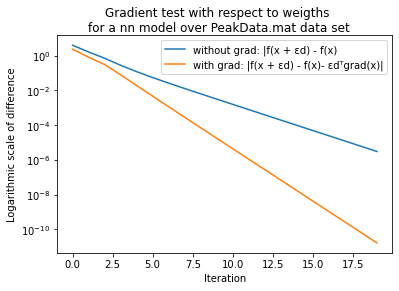

In [196]:
without_grad, with_grad = model_gradient_test_with_respect_to_biases(cross_entropy_loss, model,
                                                                X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to weigths \nfor a nn model over PeakData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

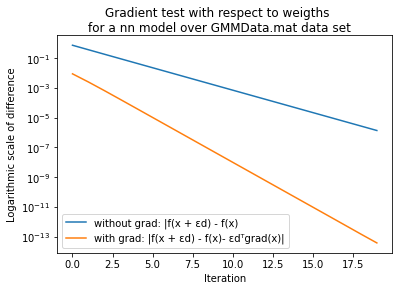

In [193]:
without_grad, with_grad = model_gradient_test_with_respect_to_biases(cross_entropy_loss, model2,
                                                                X2[:, 0].reshape(5,1), Y2[:, 0].reshape(5,1))

plt.suptitle('Gradient test with respect to weigths \nfor a nn model over GMMData.mat data set')
plt.plot(without_grad, label='without grad: |f(x + \u03B5d) - f(x)')
plt.plot(with_grad, label='with grad: |f(x + \u03B5d) - f(x)- \u03B5dᵀgrad(x)|')
plt.xlabel('Iteration')
plt.ylabel('Logarithmic scale of difference')
plt.yscale('log')
plt.legend()
plt.show()

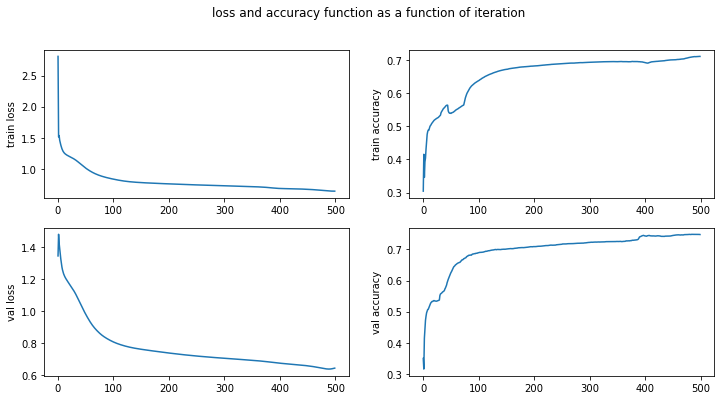

In [195]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 16, activation=tanh()),
        linear_layer(16, 5, activation=softmax())
)

loss_train, accuracy_train, loss_val, accuracy_val = SGD(model, X, Y, X_val, Y_val, 500, 0.1, cross_entropy_loss, 2500)

fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('loss and accuracy function as a function of iteration')

axs[0][0].plot(loss_train)
axs[0][0].set_ylabel('train loss')

axs[0][1].plot(accuracy_train)
axs[0][1].set_ylabel('train accuracy')

axs[1][0].plot(loss_val)
axs[1][0].set_ylabel('val loss')

axs[1][1].plot(accuracy_val)
axs[1][1].set_ylabel('val accuracy')

plt.show()

as we can see our modal 

3. *Repeat section 3 for the entire network. Try a few network lengths and see how this influences the performance. Write your conclusions and demonstrate them.*